In [1]:
import sys
sys.path.append("..")

from source.Testing import plot_roc, predict,display_recall,display_sentence_example,display_f1_score,display_accuracy_score,display_fbeta_score,plot_roc

In [3]:
predict("What does life even mean ?")

(array([[3.6755218e-03, 3.1877206e-10, 2.3321506e-10, 1.0191804e-08,
         1.6830217e-09, 9.9631977e-01, 6.4899865e-07, 4.0794130e-06]],
       dtype=float32),
 'irrelevant')

In [4]:
display_sentence_example()

{'intent': 'irrelevant', 'sentence': 'Tu sais où je peux acheter un bazooka ?'} (array([[2.02156812e-07, 2.61520561e-09, 1.54157971e-11, 3.30060573e-07,
        1.05947905e-07, 1.31330735e-05, 1.43201973e-09, 9.99986291e-01]],
      dtype=float32), 'purchase')
irrelevant find-hotel [4.0204725e-08 1.4341611e-09 9.9981922e-01 1.5436640e-11 2.3821159e-11
 1.2798970e-06 4.7362061e-09 1.7956574e-04]


In [5]:
display_recall()

recall :
micro : 	 0.8544600938967136
weighted : 	 0.8544600938967136
macro : 	 0.787534137528874


In [6]:
display_accuracy_score()

accuracy score :	 0.8544600938967136


In [7]:
display_f1_score()

f1 score : 
micro : 	 0.8544600938967136
weighted : 	 0.8513721959279645
macro : 	 0.7887151091091016


In [8]:
display_fbeta_score()

fbeta score : 
micro : 	 0.8544600938967136
weighted : 	 0.8510228215560655
macro : 	 0.7919029559279085


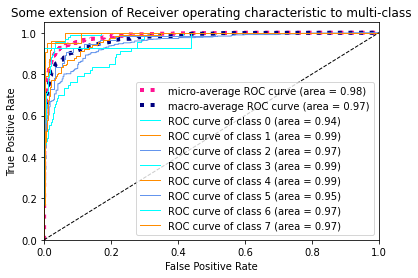

In [9]:
plot_roc()